In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from quantize.utils import set_seed
set_seed(42)
def plot_quantile_fig(data_,path,axis=-1):
    '''
    axis:需要查看的数据维度，保留的数据维度
    '''
    # width = 1
    torch.cuda.empty_cache()
    height = len(data_)
    fig,axes = plt.subplots(1,1)
    torch.cuda.synchronize(),torch.cuda.empty_cache()

    if isinstance(data_,torch.Tensor):
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    shape = data.shape
    if axis >= len(shape):
        raise ValueError("Axis should be less than data.shape")
    permuted_data = np.moveaxis(data, axis, 0)
    reshaped_data = permuted_data.reshape(shape[axis], -1).transpose(1,0)
    reshaped_data = torch.from_numpy(reshaped_data).cpu().float()
    pmax = torch.amax(reshaped_data,dim=0).cpu().numpy()
    # p9999 = torch.quantile(reshaped_data,0.9999,dim=0).cpu().numpy()
    p99 = torch.quantile(reshaped_data,0.99,dim=0).cpu().numpy()
    p75 = torch.quantile(reshaped_data,0.75,dim=0).cpu().numpy()
    p25 = torch.quantile(reshaped_data,0.25,dim=0).cpu().numpy()
    p01 = torch.quantile(reshaped_data,0.01,dim=0).cpu().numpy()
    # p0001 = torch.quantile(reshaped_data,0.0001,dim=0).cpu().numpy()
    pmin = torch.amin(reshaped_data,dim=0).cpu().numpy()
    x_label_ids = np.arange(len(pmin))
    del reshaped_data
    torch.cuda.synchronize(),torch.cuda.empty_cache()
    sns.set(style="whitegrid")
    color_minmax = "#1f77b4"  # 蓝色
    color_percentile_199 = "#d62728"  # 红色
    color_percentile_2575 = "#ff7f0e"  # 黄色

    # axes.plot(x_label_ids,p9999,color='purple',label='1/9999 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p99,color=color_percentile_199,label='1/99 Percentile',linewidth=0.5,alpha=0.8)
    axes.plot(x_label_ids,p75,color=color_percentile_2575,label='25/75 Percentile',linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p25,color=color_percentile_2575,linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p01,color=color_percentile_199,linewidth=0.5,alpha=0.8)
    # axes.plot(x_label_ids,p0001,color='purple',linewidth=0.5)
    axes.plot(x_label_ids,pmax,color=color_minmax,linewidth=0.5,alpha=1)
    axes.plot(x_label_ids,pmin,color=color_minmax,label='Min/Max',linewidth=0.5,alpha=1)

    axes.set_xlabel('Hidden dimension index')
    axes.set_ylabel('Activation value')
    axes.legend(loc='upper right')

    fig.tight_layout(rect=[0,0.05,1,0.95])
    # fig.savefig(path,dpi=300)
    # print("saveing: ",path)
    # plt.close()
    plt.show()

In [2]:
import torch
data = torch.load("/data01/home/jiangzx/mamba_quant_comp/model_vim_quant/saved_checkpoint/mamba2d_b.pth")

In [3]:
data['state_dict'].keys()

odict_keys(['backbone.pos_embed', 'backbone.patch_embed.projection.weight', 'backbone.patch_embed.projection.bias', 'backbone.layers.0.mixer.A_log', 'backbone.layers.0.mixer.D', 'backbone.layers.0.mixer.in_proj.weight', 'backbone.layers.0.mixer.conv1d.weight', 'backbone.layers.0.mixer.conv1d.bias', 'backbone.layers.0.mixer.x_proj.weight', 'backbone.layers.0.mixer.dt_proj.weight', 'backbone.layers.0.mixer.dt_proj.bias', 'backbone.layers.0.mixer.out_proj.weight', 'backbone.layers.0.norm.weight', 'backbone.layers.0.norm.bias', 'backbone.layers.1.mixer.A_log', 'backbone.layers.1.mixer.D', 'backbone.layers.1.mixer.in_proj.weight', 'backbone.layers.1.mixer.conv1d.weight', 'backbone.layers.1.mixer.conv1d.bias', 'backbone.layers.1.mixer.x_proj.weight', 'backbone.layers.1.mixer.dt_proj.weight', 'backbone.layers.1.mixer.dt_proj.bias', 'backbone.layers.1.mixer.out_proj.weight', 'backbone.layers.1.norm.weight', 'backbone.layers.1.norm.bias', 'backbone.layers.2.mixer.A_log', 'backbone.layers.2.mixe

In [4]:
tensor = data['state_dict']['backbone.layers.13.mixer.dt_proj.weight']

In [5]:
tensor.shape

torch.Size([1536, 48])

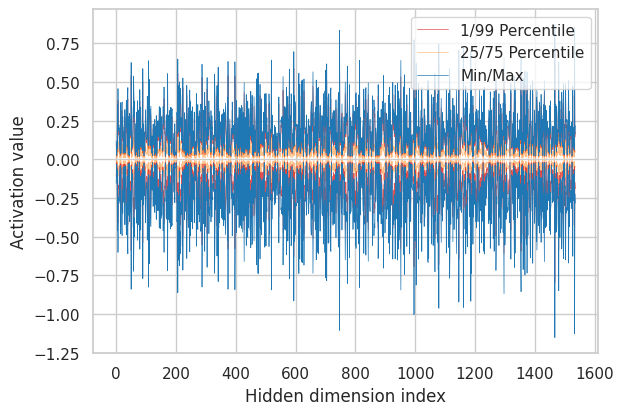

In [16]:
import numpy as np

# 第一步：创建一个形状为(8, 8)的随机numpy数组
tensor = data['state_dict']['backbone.layers.13.mixer.out_proj.weight'].cpu().numpy()

# # 对每一行进行初始化，使均值为0，但方差不同
for i in range(tensor.shape[1]):
    stddev = np.abs(np.random.randn(1)).item()  # 随机生成一个正数，作为标准差
    tensor[:,i] = tensor[:,0]*2 * stddev + tensor[:,i]*0.2 # 使每一行的均值为0，方差不同

# 验证每行的均值和方差
means = tensor.mean(axis=1)
variances = tensor.var(axis=1)

# print("每行的均值（应接近0）:", means)
# print("每行的方差（应相差极大）:", variances)
plot_quantile_fig(torch.from_numpy(tensor),"/data01/home/xuzk/mamba_quant_comp/model_vim_quant/data/tmp_data/quantile.png",axis=-1)

In [8]:
from quantize.hadamard_utils import random_hadamard_matrix
import fast_hadamard_transform
H = random_hadamard_matrix(tensor.shape[-1],torch.device("cpu"))
H = H.T

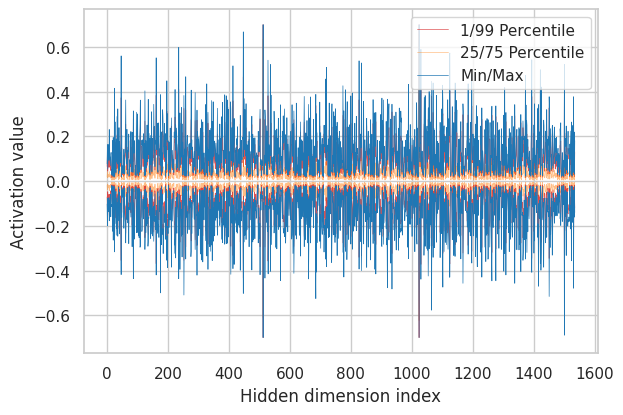

In [19]:
hadamard_tensor = fast_hadamard_transform.hadamard_transform(torch.from_numpy(tensor).cuda().contiguous(), 1.0/torch.tensor(tensor.shape[1]).sqrt())
hadamard_tensor[:,0] = hadamard_tensor[:,0]/100
plot_quantile_fig(hadamard_tensor.clamp(-0.7,0.7),"/data01/home/jiangzx/mamba_quant_comp/model_vim_quant/hadamard_quantile.png",axis=-1)

saveing:  /data01/home/jiangzx/mamba_quant_comp/model_vim_quant/klt_quantile.png


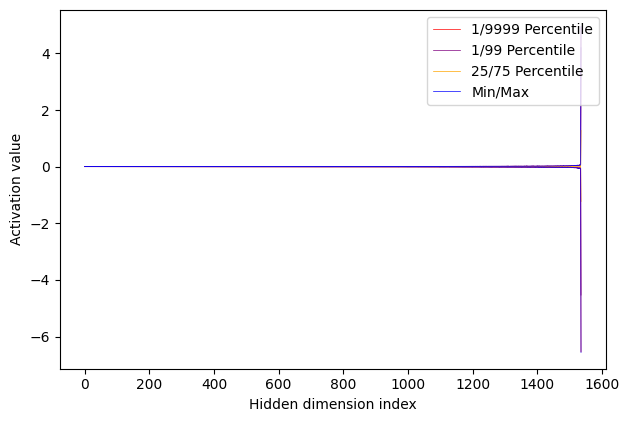

saveing:  /data01/home/jiangzx/mamba_quant_comp/model_vim_quant/klt_quantile.png


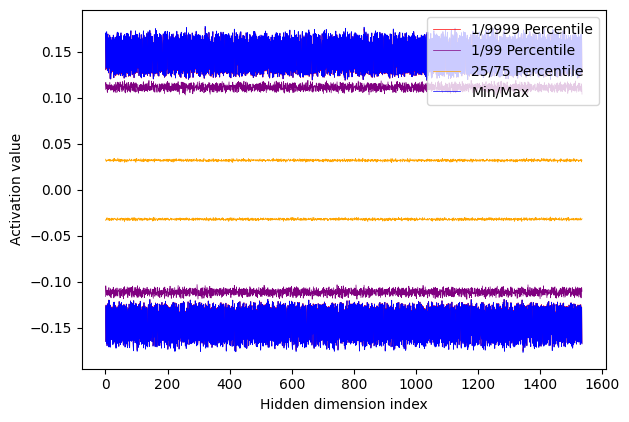

In [72]:

cov_matrix = np.cov(tensor, rowvar=False)

# 2. 对协方差矩阵进行特征值分解，得到特征向量矩阵 V
eigenvalues, V = np.linalg.eigh(cov_matrix)

# 3. 将矩阵 X 投影到特征向量矩阵 V 上，得到 Y = X * V
klt_tensor = torch.from_numpy(tensor @ V).float().cuda().contiguous()
# klt_tensor = fast_hadamard_transform.hadamard_transform(torch.from_numpy(tensor @ V).float().cuda().contiguous(), 1.0/torch.tensor(tensor.shape[1]).sqrt())
klt_hadamard_tensor=fast_hadamard_transform.hadamard_transform(torch.from_numpy(tensor @ V).float().cuda().contiguous(), 1.0/torch.tensor(tensor.shape[1]).sqrt())
plot_quantile_fig(klt_tensor,"/data01/home/jiangzx/mamba_quant_comp/model_vim_quant/klt_quantile.png",axis=-1)
plot_quantile_fig(klt_hadamard_tensor,"/data01/home/jiangzx/mamba_quant_comp/model_vim_quant/klt_quantile.png",axis=-1)

In [53]:
# test = np.cov(klt_tensor,rowvar=False)


# import matplotlib.pyplot as plt
# plt.imshow(test, cmap='viridis', interpolation='none')

# # 添加颜色条，帮助解释矩阵值的大小
# plt.colorbar()

# # 显示矩阵值
# for i in range(test.shape[0]):
#     for j in range(test.shape[1]):
#         plt.text(j, i, f'{test[i, j]:.2f}', ha='center', va='center', color='white')

# # 显示图像
# plt.show()
# test


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [52]:


cov_Y = np.cov(klt_tensor.cpu(), rowvar=False)

# 输出协方差矩阵
print("Y 的协方差矩阵：")
print(cov_Y)

# 检查协方差矩阵是否为对角矩阵
is_diagonal = np.allclose(cov_Y, np.diag(np.diag(cov_Y)))
print(f"Y 的协方差矩阵是否为对角矩阵: {is_diagonal}")


Y 的协方差矩阵：
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.20602550e-02
  -1.87582035e-11  3.83095624e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.87582035e-11
   2.51976473e-02 -1.53145771e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.83095624e-11
  -1.53145771e-11  9.13229138e-01]]
Y 的协方差矩阵是否为对角矩阵: True
